In [1]:
import sys
sys.path.append('../../src')
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from sindy_utils import D_Lele
import wsindy_utils
import tensorflow as tf 

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

In [2]:
x0 = -3
x1 = 3
tstop = 1
nx = 1001
nt = 1000
amp = np.array([0.7])
width = np.array([0.9])
save_data = False

# amp = np.linspace(0.7,0.9,5)
# width = np.linspace(0.9,1.1,5)

In [3]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
def sine_wave(amp, width):
    u0 = np.zeros(nx)
    u0[1:int(width/dx+1)] =amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    return u0

def gaussian(amp, width, x):
    u0 = amp*np.exp(-(x-0.0)**2/(2*width**2))
    u0[-1] = u0[0]
    return u0

def residual(un, uw, c, idxn1):
    # r = -u^{n} + u^{n+1} -dt*f(u^{n+1})
    f = c*(uw**2 - uw*uw[idxn1]) 
    r = -un + uw + f
    return r

def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs

def jacobian(u, c, idxn1, nx):
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    subdiag_comp = np.ones(nx-1)
    subdiag_comp[:-1] = -c*u[1:]
    data = np.array([diag_comp, subdiag_comp])
    J = spdiags(data,[0,-1],nx-1,nx-1,format='csr')
    J[0,-1] = -c*u[0]
    return J

def solve(u0, maxk, convergence_threshold, nt, nx, idxn1, c):
    u = np.zeros((nt+1,nx))
    u_inter=np.array([])
    u[0] = u0
    u_inter=np.append(u_inter,u0[:-1])
    I = sparse.eye(nx,format='csr')
    for n in range(nt): 
        uw = u[n,:-1].copy()
        r = residual(u[n,:-1], uw, c, idxn1)
        
        for k in range(maxk):
            J = jacobian(uw, c, idxn1, nx)
            duw = spsolve(J, -r)
            uw = uw + duw
            r = residual(u[n,:-1], uw, c, idxn1)
            u_inter = np.append(u_inter, uw)

            rel_residual = np.linalg.norm(r)/np.linalg.norm(u[n,:-1])
            if rel_residual < convergence_threshold:
                u[n+1,:-1] = uw.copy()
                u[n+1,-1] = u[n+1,0]
                break
    return u,u_inter.reshape((-1,nx-1))

 
def gen_data(amp_arr, width_arr, x0, x1, tstop, nx, nt, noise_ratio):
    maxk = 10
    convergence_threshold = 1.0e-8
    x = np.linspace(x0, x1, nx)
    dx = (x1-x0) / (nx - 1)
    t = np.linspace(0, tstop, nt)
    dt = tstop / nt 
    c = dt/dx
    degree = 1 
    thres = 1

    idxn1 = np.zeros(nx-1,dtype='int')
    idxn1[1:] = np.arange(nx-2)
    idxn1[0] = nx-2
    timer = []
    
    # compute x
    timer.append(time())
    num_amp = amp_arr.shape[0]
    num_width = width_arr.shape[0]
    soln = []
    for i in range(num_amp):
        for j in range(num_width):
            u0 = gaussian(amp_arr[i],width_arr[j],x)
#             u0=sine_wave(amp_arr[i],width_arr[j])
            u,_ = solve(u0, maxk, convergence_threshold, nt, nx, idxn1, c)
            soln.append(u)
    soln = np.vstack(soln)    
    
    soln = addNoise(soln, noise_ratio)

     # compute dx/dt
    timer.append(time())
    data_x = soln.reshape(-1,nt+1,nx)
    dxdt_full = []
    t_full = []
    for num in range(len(data_x)):
        X = data_x[num] # exclude the last time step
        dxdt = np.empty(X.shape)
        D = D_Lele(X.shape[0],tstop/X.shape[0])   
        for i in range(X.shape[1]):
            dxdt[:,i] = np.dot(D.toarray(), X[:,i])
        dxdt_full.extend(dxdt)
        t_full.append(np.linspace(0,tstop,nt+1).reshape(-1,1))
    del D
    dxdt = np.array(dxdt_full)
    t = np.vstack(t_full)
    timer.append(time())
    
    time_fom = [timer[2]-timer[1], timer[1]-timer[0]]
    data = {}
    data['t'] = t
    data['x'] = soln
    data['dx'] = dxdt
    data['time_fom'] = time_fom
    return data

In [5]:
data = []
param = []
for i in amp:
    for j in width:
        tmp = gen_data(np.array([i]), np.array([j]), x0, x1, tstop, nx, nt, 0.1)
        data.append(tmp)
        param.append(np.array([i, j]))
data_all = {}
data_all['data'] = data
data_all['param'] = param
    

num_case = len(data_all['data'])
param = data_all['param']
time1 = 0
time2 = 0
time3 = 0
print(f'number of cases: {num_case}')
for i in range(num_case):
    print(f"Case {i+1}: A: {param[i][0]:.2f}, W: {param[i][1]:.2f}, t: {data_all['data'][i]['t'].shape}, x: {data_all['data'][i]['x'].shape}, dx: {data_all['data'][i]['dx'].shape}")
    time1 += data_all['data'][i]['time_fom'][0]
    time2 += data_all['data'][i]['time_fom'][1]
    time3 = time1 + time2
    
print(f"time for computing x: {time1/num_case:.2f} s")
print(f"time for computing dx: {time2/num_case:.2f} s")
print(f'total time: {time3/num_case:.2f} s')

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


number of cases: 1
Case 1: A: 0.70, W: 0.90, t: (1001, 1), x: (1001, 1001), dx: (1001, 1001)
time for computing x: 3.34 s
time for computing dx: 1.94 s
total time: 5.28 s


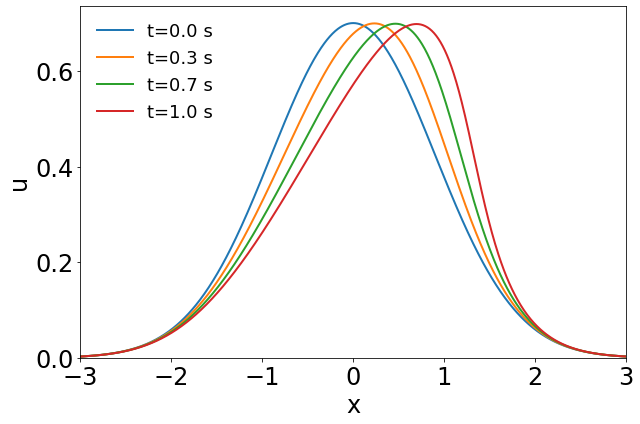

In [13]:
t = np.linspace(0,tstop,nt+1)
x = np.linspace(x0,x1,nx)
step_list = np.linspace(0,nt,4,dtype=int)

fig1 = plt.figure(figsize=(9,6))
idx = np.arange(0,t.size,50)
ax = fig1.add_subplot(111)
for i,step in enumerate(step_list):
    ax.plot(x, data_all['data'][0]['x'][step,:], '-', lw=2, c=cmap(i), label=f't={t[step]:.1f} s')

ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('u', fontsize=24)
ax.set_xlim(x.min(),x.max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', labelsize=24)
ax.legend(loc='upper left', frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig(f"./1Dburger_dynamics_noisefree.png",bbox_inches='tight')

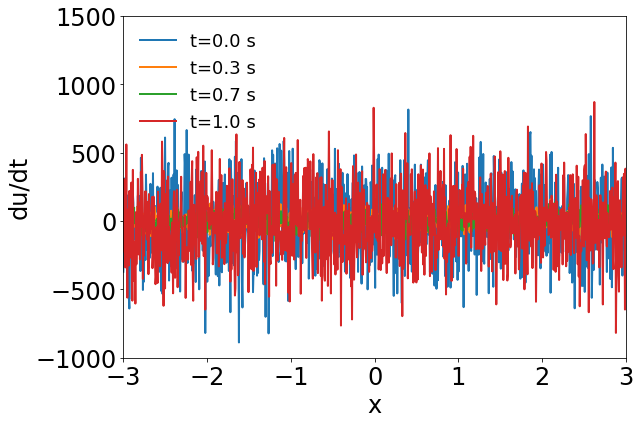

In [10]:
t = np.linspace(0,tstop,nt+1)
x = np.linspace(x0,x1,nx)
step_list = np.linspace(0,nt,4,dtype=int)

fig1 = plt.figure(figsize=(9,6))
idx = np.arange(0,t.size,50)
ax = fig1.add_subplot(111)
for i,step in enumerate(step_list):
    ax.plot(x, data_all['data'][0]['dx'][step,:], '-', lw=2, c=cmap(i), label=f't={t[step]:.1f} s')

ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('du/dt', fontsize=24)
ax.set_xlim(x.min(),x.max())
ax.set_ylim(bottom=-1000, top=1500)
ax.tick_params(axis='both', labelsize=24)
ax.legend(loc='upper left', frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig(f"./1Dburger_dynamics_gradient_noisy.png",bbox_inches='tight')

In [ ]:
# save data
if save_data:
    # data_path = './data'
    # data_path = '/usr/workspace/he10/data/1DBurgerEqn'
    data_path = '/usr/workspace/he10/data/1DBurgerEqn/noisy'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        print('here')
    if num_case > 1:
        # pickle.dump(data_all, open(data_path + f"/local{num_case}.p", "wb"))
        pickle.dump(data_all, open(data_path + f"/local{num_case}_10pc_noise.p", "wb"))
    else:
        pickle.dump(data_all, open(data_path + f"/local{num_case}_A{amp[0]:.2f}_W{width[0]:.2f}_10pc_noise.p", "wb"))